<a href="https://colab.research.google.com/github/ruthreich-star/LoanDefault/blob/main/LoanDeaultModel_final66.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# הסרה של גרסאות קיימות
#!pip uninstall -y xgboost scikit-learn autoviz

# התקנת גרסאות תואמות:
#!pip install xgboost==1.6.2 scikit-learn==1.4.2 autoviz

# לאחר ההתקנה – חובה לאתחל את הסשן:
# import os, sys
# os.kill(os.getpid(), 9)

import xgboost, sklearn
import inspect

print("xgboost:", xgboost.__version__)
print("sklearn:", sklearn.__version__)
print("xgboost location:", inspect.getfile(xgboost))



xgboost: 3.1.1
sklearn: 1.6.1
xgboost location: /usr/local/lib/python3.12/dist-packages/xgboost/__init__.py


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from google.colab import files
import pickle
import os
from scipy import stats
from scipy.stats import zscore

!pip install missingno
import missingno as msno

!pip install fancyimpute
import fancyimpute
import sklearn, xgboost
#!pip install --upgrade autoviz
#from autoviz.AutoViz_Class import AutoViz_Class
#!pip install -U "xgboost>=2.0.3"
# מומלץ לאשר ריסטרט: Runtime → Restart runtime

print("sklearn:", sklearn.__version__, "xgboost:", xgboost.__version__)

warnings.filterwarnings("ignore")
%matplotlib inline

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.6 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=a17c1dca3fe7efb9ed08a299798272a9346a732011f9a416eabbcf910c543191
  Stored in directory: /root/.cache/pip/wheels/df/20/91/e4850b9a31cf660c1bc95515d3bcbc8010e869e5de6d5baf07
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=313386143abd173e79a2f7f015bb17bbedafdc08ca233a3b349f21a37ff7e808
  Stored in directory: /root/.cache/pip/wheels/89/11/61/aa5a3167bfff49218cd043a73a83034b9eadd858b0059521be
Successfully built fancyimpute knnimpute
sklearn: 1.6.1 xgboost: 3.1.1


In [ ]:
np.random.seed(31071967)

In [ ]:
download_pickels = True

In [4]:
import os, pathlib, sys
!mkdir -p pickles
pickle_file = '/content/pickles/load_default_feature_eng.pkl'

if not os.path.exists(pickle_file):
# Upload file
  uploaded = files.upload()

# Read pickle into DataFrame
df = pd.read_pickle(pickle_file)

df.head(10)

,id,loan_amnt,installment,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,inq_last_6mths,...,last_credit_pull_d_year,last_credit_pull_d_month,months_between_las_p_to_issue,credit_age_months,underfunded_amt,platform_share_amt,term_num,amount_x_rate,rate_x_term,repay_fail
0,545583,2500,85.0,5,4,20004.0,9,22,19.86,5.0,...,2016.0,6.0,36,59,0,0,36,349.5,5.0328,0
1,532101,5000,176.0,5,4,59000.0,2,33,19.57,1.0,...,2012.0,3.0,17,194,0,0,36,797.5,5.7420,1
2,877788,7000,226.0,2,0,53796.0,9,42,10.80,3.0,...,2014.0,3.0,30,162,0,0,36,693.7,3.5676,0
3,875406,2000,60.0,2,4,30000.0,2,33,3.60,0.0,...,2016.0,6.0,29,440,0,0,36,108.4,1.9512,0
4,506439,3600,117.0,2,0,675048.0,9,1,1.55,4.0,...,2016.0,6.0,37,144,0,0,36,369.0,3.6900,0
5,981465,8000,243.0,2,0,77736.0,9,3,6.07,0.0,...,2014.0,4.0,30,183,0,0,36,482.4,2.1708,0
6,749050,6000,187.0,4,4,35000.0,2,24,13.13,0.0,...,2014.0,5.0,36,91,0,0,36,449.4,2.6964,0
7,1016373,25600,599.0,5,4,86000.0,2,33,26.51,1.0,...,2016.0,6.0,29,337,127,127,60,3653.12,8.5620,0
8,786870,19750,559.0,2,0,72500.0,2,24,19.96,0.0,...,2016.0,2.0,24,231,0,0,60,4585.95,13.9320,0
9,1019261,6250,224.0,5,0,28000.0,9,34,13.76,0.0,...,2014.0,9.0,29,145,0,0,36,1079.375,6.2172,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38478 entries, 0 to 38477
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             38478 non-null  int64  
 1   loan_amnt                      38478 non-null  Int64  
 2   installment                    38478 non-null  float64
 3   emp_length                     38478 non-null  int8   
 4   home_ownership                 38478 non-null  int8   
 5   annual_inc                     38478 non-null  float64
 6   purpose                        38478 non-null  int8   
 7   addr_state                     38478 non-null  int8   
 8   dti                            38478 non-null  float64
 9   inq_last_6mths                 38478 non-null  float64
 10  open_acc                       38478 non-null  float64
 11  pub_rec                        38478 non-null  float64
 12  revol_bal                      38478 non-null 

In [6]:
#df['amount_x_rate'] = pd.to_numeric(df['amount_x_rate'], errors='coerce').astype('float32')
df_model = df.drop(columns=['id'], errors='ignore')

In [10]:
from sklearn.model_selection import train_test_split
#df_model = df.copy()
# Assuming df_model is already defined and contains the necessary features and target variable


# Define the target and feature set
X = df_model.drop(columns=['repay_fail'])
y = df_model['repay_fail']

# Total number of samples
total_samples = len(df_model)

# First split: training and temporary (test + dev)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: testing and development (dev)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages
print(f"Training set size: {train_percent:.2f}%")
print(f"Validation (Dev) set size: {dev_percent:.2f}%")
print(f"Testing set size: {test_percent:.2f}%")

# --- Apply class balancing on training data ---
from imblearn.combine import SMOTETomek

# Initialize SMOTETomek
smt = SMOTETomek(random_state=47)
# Convert the entire dataframes to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Apply it only on the training set
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print("Before balancing:", y_train.value_counts())
print("After balancing:", y_train_res.value_counts())

Training set size: 70.00%
Validation (Dev) set size: 15.00%
Testing set size: 15.00%
Before balancing: repay_fail
0    22852
1     4082
Name: count, dtype: int64
After balancing: repay_fail
0    21994
1    21994
Name: count, dtype: int64


In [11]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier #Regressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [12]:
print(xgboost.__version__)

3.1.1


In [13]:
#!pip install -U "xgboost>=2.0.3"
print("sklearn:", sklearn.__version__, "xgboost:", xgboost.__version__)


sklearn: 1.6.1 xgboost: 3.1.1


In [ ]:
# !pip install -U xgboost

# # If you need to be explicit/pinned:
# !pip install -U "scikit-learn==1.6.1" "xgboost>=2.1.4"


In [14]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38478 entries, 0 to 38477
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   loan_amnt                      38478 non-null  Int64  
 1   installment                    38478 non-null  float64
 2   emp_length                     38478 non-null  int8   
 3   home_ownership                 38478 non-null  int8   
 4   annual_inc                     38478 non-null  float64
 5   purpose                        38478 non-null  int8   
 6   addr_state                     38478 non-null  int8   
 7   dti                            38478 non-null  float64
 8   inq_last_6mths                 38478 non-null  float64
 9   open_acc                       38478 non-null  float64
 10  pub_rec                        38478 non-null  float64
 11  revol_bal                      38478 non-null  float64
 12  revol_util                     38478 non-null 

In [15]:
# --- classification function ---
def classificationMetrics(y, yhat):
    prf1 = metrics.precision_recall_fscore_support(y,yhat)
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision':prf1[0][1],
           'Recall': prf1[1][1],
           'f1-score': prf1[2][1],
           'Log-loss': metrics.log_loss(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res
# --- models dictionary ---
models = {
    "LogisticClassifier": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "SVC": SVC(),
    "XGBClassifier": xgboost.XGBClassifier(objective="reg:squarederror")
}

# --- train, predict, and evaluate on DEV set ---
results = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_dev_pred = model.predict(X_dev)
    m = classificationMetrics(y_dev, y_dev_pred)
    results.append({"Model": name, **m})

# --- results table ---
df_results = pd.DataFrame(results)
df_results

,Model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
0,LogisticClassifier,0.654019,0.235981,0.582468,0.335883,12.470405,0.624567
1,DecisionTreeClassifier,0.818261,0.411306,0.486736,0.445853,6.550553,0.681798
2,RandomForestClassifier,0.879764,0.648370,0.435986,0.521379,4.333731,0.697096
3,AdaBoostClassifier,0.811157,0.399095,0.508651,0.447262,6.806580,0.686639
4,GradientBoostingClassifier,0.871102,0.576020,0.537486,0.556086,4.645959,0.733778
5,SVC,0.585412,0.201487,0.594002,0.300906,14.943254,0.588948
6,XGBClassifier,0.909217,0.753323,0.588235,0.660622,3.272154,0.777094


The table presents a comparison of classification models using standard evaluation metrics.

General rule of thumb:

Higher is better: Accuracy, Precision, Recall, F1-score, AUC

Lower is better: Log-loss

Which model performs best?

The XGBClassifier outperforms all other models across almost all metrics:

This means that XGBClassifier:

Detects the highest number of positive cases (high Recall),

Maintains a low number of False Positives (high Precision),

Is well-balanced between Precision and Recall (high F1-score),

Produces well-calibrated probability outputs (low Log-loss),

And has excellent overall discrimination ability between the classes (high AUC).

**Finetuning Evaluation**

In [16]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb = XGBClassifier(
    random_state=42,
    tree_method="hist",   # fast default
    n_jobs=-1,
    eval_metric="auc"     # good default for binary clsf.
)

param_dist = {
    "n_estimators": [200, 400, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.7, 0.85, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 1e-3, 1e-2, 1e-1],
    "reg_lambda": [0.5, 1.0, 2.0],
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)
print(random_search.best_params_)
print(random_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
0.9902606849439465


In [17]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, average_precision_score
)
random_search.fit(X_train_res, y_train_res)
print("Best params:", random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)

best_model = random_search.best_estimator_

# TEST
y_proba = best_model.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Test PR-AUC :", average_precision_score(y_test, y_proba))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV ROC-AUC: 0.9902606849439465
Test ROC-AUC: 0.939553079821723
Test PR-AUC : 0.7938279263022523


***Conclusion*** using finetuning parameters

In [18]:
# ----- 1) Best hyperparameters you found -----
best_params = {
    "subsample": 1.00,
    "reg_lambda": 1.0,
    "reg_alpha": 0.001,
    "n_estimators": 400,
    "min_child_weight": 1,
    "max_depth": 6,
    "learning_rate": 0.1,
    "gamma": 0.1,
    "colsample_bytree": 1.00,
}

# ----- 2) Fit XGBoost with those params -----
xgb_best = XGBClassifier(
    random_state=42,
    tree_method="hist",      # fast CPU histogram algorithm
    n_jobs=-1,
    eval_metric="logloss",   # convenient for computing log-loss; AUC computed separately
    **best_params
)

xgb_best.fit(X_train, y_train)

# ----- 3) Predict on the test set -----
y_proba = xgb_best.predict_proba(X_test)[:, 1]   # class-1 probabilities
y_pred  = (y_proba >= 0.5).astype(int)           # decision threshold (can be tuned)

# ----- 4) Compute all metrics -----
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
ll   = log_loss(y_test, y_proba)
roc  = roc_auc_score(y_test, y_proba)
pra  = average_precision_score(y_test, y_proba)  # PR-AUC (Average Precision)

# ----- 5) Assemble the results into an English table -----
rows = [
    {
        "Metric": "Accuracy",
        "What it means": "Share of correct predictions over all samples",
        "How it’s computed": "(TP + TN) / (TP + TN + FP + FN)",
        "Good value": "High (close to 1). Can be misleading with class imbalance.",
        "Your model": f"{acc:.4f}",
    },
    {
        "Metric": "Precision",
        "What it means": "Of all predicted positives, how many are truly positive?",
        "How it’s computed": "TP / (TP + FP)",
        "Good value": "High (≈0.8–1). Low means many false positives.",
        "Your model": f"{prec:.4f}",
    },
    {
        "Metric": "Recall (Sensitivity)",
        "What it means": "Of all true positives, how many did the model catch?",
        "How it’s computed": "TP / (TP + FN)",
        "Good value": "High (≈0.8–1). Low means many missed positives.",
        "Your model": f"{rec:.4f}",
    },
    {
        "Metric": "F1-score",
        "What it means": "Harmonic mean of Precision and Recall (balance between them)",
        "How it’s computed": "2 × (P × R) / (P + R)",
        "Good value": "Closer to 1 is better, especially with class imbalance.",
        "Your model": f"{f1:.4f}",
    },
    {
        "Metric": "Log-loss",
        "What it means": "Penalty for wrong/confident probability estimates",
        "How it’s computed": "Cross-entropy on predicted probabilities",
        "Good value": "Lower is better (0 is ideal).",
        "Your model": f"{ll:.6f}",
    },
    {
        "Metric": "ROC-AUC",
        "What it means": "Area under ROC; separation ability across all thresholds",
        "How it’s computed": "Based on TPR vs. FPR over thresholds",
        "Good value": "Close to 1 (0.5 is random).",
        "Your model": f"{roc:.4f}",
    },
    {
        "Metric": "PR-AUC (Average Precision)",
        "What it means": "Area under Precision–Recall; sensitive to class imbalance",
        "How it’s computed": "Weighted average of Precision over Recall",
        "Good value": "Higher is better; useful with rare positives.",
        "Your model": f"{pra:.4f}",
    },
]

metrics_table_en = pd.DataFrame(
    rows,
    columns=["Metric", "What it means", "How it’s computed", "Good value", "Your model"]
)

metrics_table_en


,Metric,What it means,How it’s computed,Good value,Your model
0,Accuracy,Share of correct predictions over all samples,(TP + TN) / (TP + TN + FP + FN),High (close to 1). Can be misleading with clas...,0.9201
1,Precision,"Of all predicted positives, how many are truly...",TP / (TP + FP),High (≈0.8–1). Low means many false positives.,0.8167
2,Recall (Sensitivity),"Of all true positives, how many did the model ...",TP / (TP + FN),High (≈0.8–1). Low means many missed positives.,0.6132
3,F1-score,Harmonic mean of Precision and Recall (balance...,2 × (P × R) / (P + R),"Closer to 1 is better, especially with class i...",0.7005
4,Log-loss,Penalty for wrong/confident probability estimates,Cross-entropy on predicted probabilities,Lower is better (0 is ideal).,0.210304
5,ROC-AUC,Area under ROC; separation ability across all ...,Based on TPR vs. FPR over thresholds,Close to 1 (0.5 is random).,0.9374
6,PR-AUC (Average Precision),Area under Precision–Recall; sensitive to clas...,Weighted average of Precision over Recall,Higher is better; useful with rare positives.,0.7876


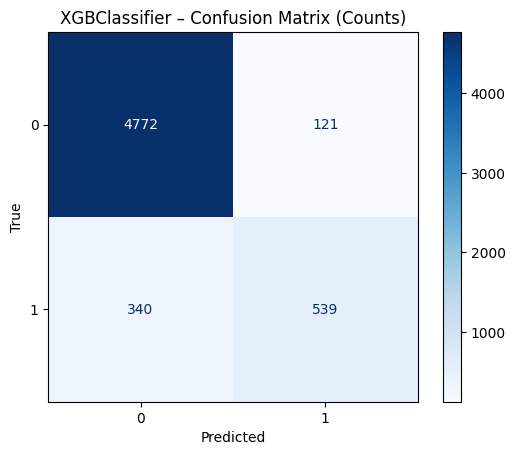

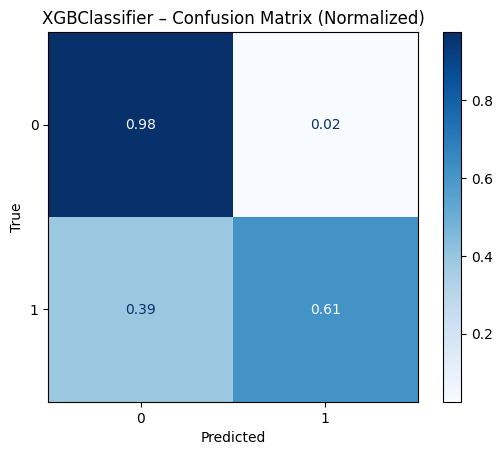

Accuracy:   0.9201
Precision:  0.8167
Recall:     0.6132
F1-score:   0.7005
Log-loss:   0.2103
ROC-AUC:    0.9374

              precision    recall  f1-score   support

           0     0.9335    0.9753    0.9539      4893
           1     0.8167    0.6132    0.7005       879

    accuracy                         0.9201      5772
   macro avg     0.8751    0.7942    0.8272      5772
weighted avg     0.9157    0.9201    0.9153      5772



In [19]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, classification_report
)
import matplotlib.pyplot as plt

# --- 1) Confusion Matrix (counts) ---
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap="Blues", values_format="d")
plt.title("XGBClassifier – Confusion Matrix (Counts)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# --- 2) Confusion Matrix (normalized by true class) ---
cm_norm = confusion_matrix(y_test, y_pred, labels=[0,1], normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0,1])
disp_norm.plot(cmap="Blues", values_format=".2f")
plt.title("XGBClassifier – Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# --- 3) Metrics (using y_pred and y_proba) ---
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
ll   = log_loss(y_test, y_proba)                 # uses probabilities
auc  = roc_auc_score(y_test, y_proba)            # uses probabilities

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print(f"F1-score:   {f1:.4f}")
print(f"Log-loss:   {ll:.4f}")
print(f"ROC-AUC:    {auc:.4f}\n")

# דו"ח מלא לפי מחלקות (0/1)
print(classification_report(y_test, y_pred, digits=4))
